### U-Net 구조 살펴보기

In [1]:
!pip install graphviz -qq
!pip install pydot -qq

In [2]:
import tensorflow.keras.layers as layers
import tensorflow as tf

<div style="display: flex;">
    <img src="./unet_1.png" style="flex: 1; margin-right: 5px; max-width: 49%;">
    <img src="./unet_2.png" style="flex: 1; margin-left: 5px; max-width: 49%;">
</div>

In [19]:
inputs = layers.Input(shape=(572, 572, 1))

##### Contracting path
# [1]
conv0 = layers.Conv2D(64, activation='relu', kernel_size = 3)(inputs)
conv1 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv0)  # Skip connection으로 Expanding path로 이어질 예정
conv2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv1)

# [2]
conv3 = layers.Conv2D(128, activation='relu', kernel_size = 3)(conv2)
conv4 = layers.Conv2D(128, activation='relu', kernel_size = 3)(conv3) 
conv5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv4)

# [3]
conv6 = layers.Conv2D(256, activation='relu', kernel_size = 3)(conv5)
conv7 = layers.Conv2D(256, activation='relu', kernel_size = 3)(conv6) 
conv8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv7)

# [4]
conv9 = layers.Conv2D(512, activation='relu', kernel_size = 3)(conv8)
conv10 = layers.Conv2D(512, activation='relu', kernel_size = 3)(conv9)
conv11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv10)

# [5]
conv12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv11)
conv13 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv12)

##### Expanding path
# [6]
trans01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(conv13)
crop01 = layers.Cropping2D(cropping=(4, 4))(conv10)
concat01 = layers.concatenate([trans01, crop01], axis=-1)

# [7]
conv14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
conv15 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv14)
trans02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(conv15)

# [8]
crop02 = layers.Cropping2D(cropping=(16, 16))(conv7)
concat02 = layers.concatenate([trans02, crop02], axis=-1)

# [9]
conv16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
conv17 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv16)
trans03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(conv17)

# [10]
crop03 = layers.Cropping2D(cropping=(40, 40))(conv4)
concat03 = layers.concatenate([trans03, crop03], axis=-1)

# [11]
conv18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
conv19 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv18)
trans04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(conv19)

#[12]
crop04 = layers.Cropping2D(cropping=(88, 88))(conv1)
concat04 = layers.concatenate([trans04, crop04], axis=-1)

# [13]
conv20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
conv21 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv20)
######

outputs = layers.Conv2D(2, kernel_size=1)(conv21)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

In [20]:
model.summary()

Model: "u-netmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 570, 570, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 568, 568, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 284, 284, 64) 0           conv2d_20[0][0]                  
_________________________________________________________________________________________

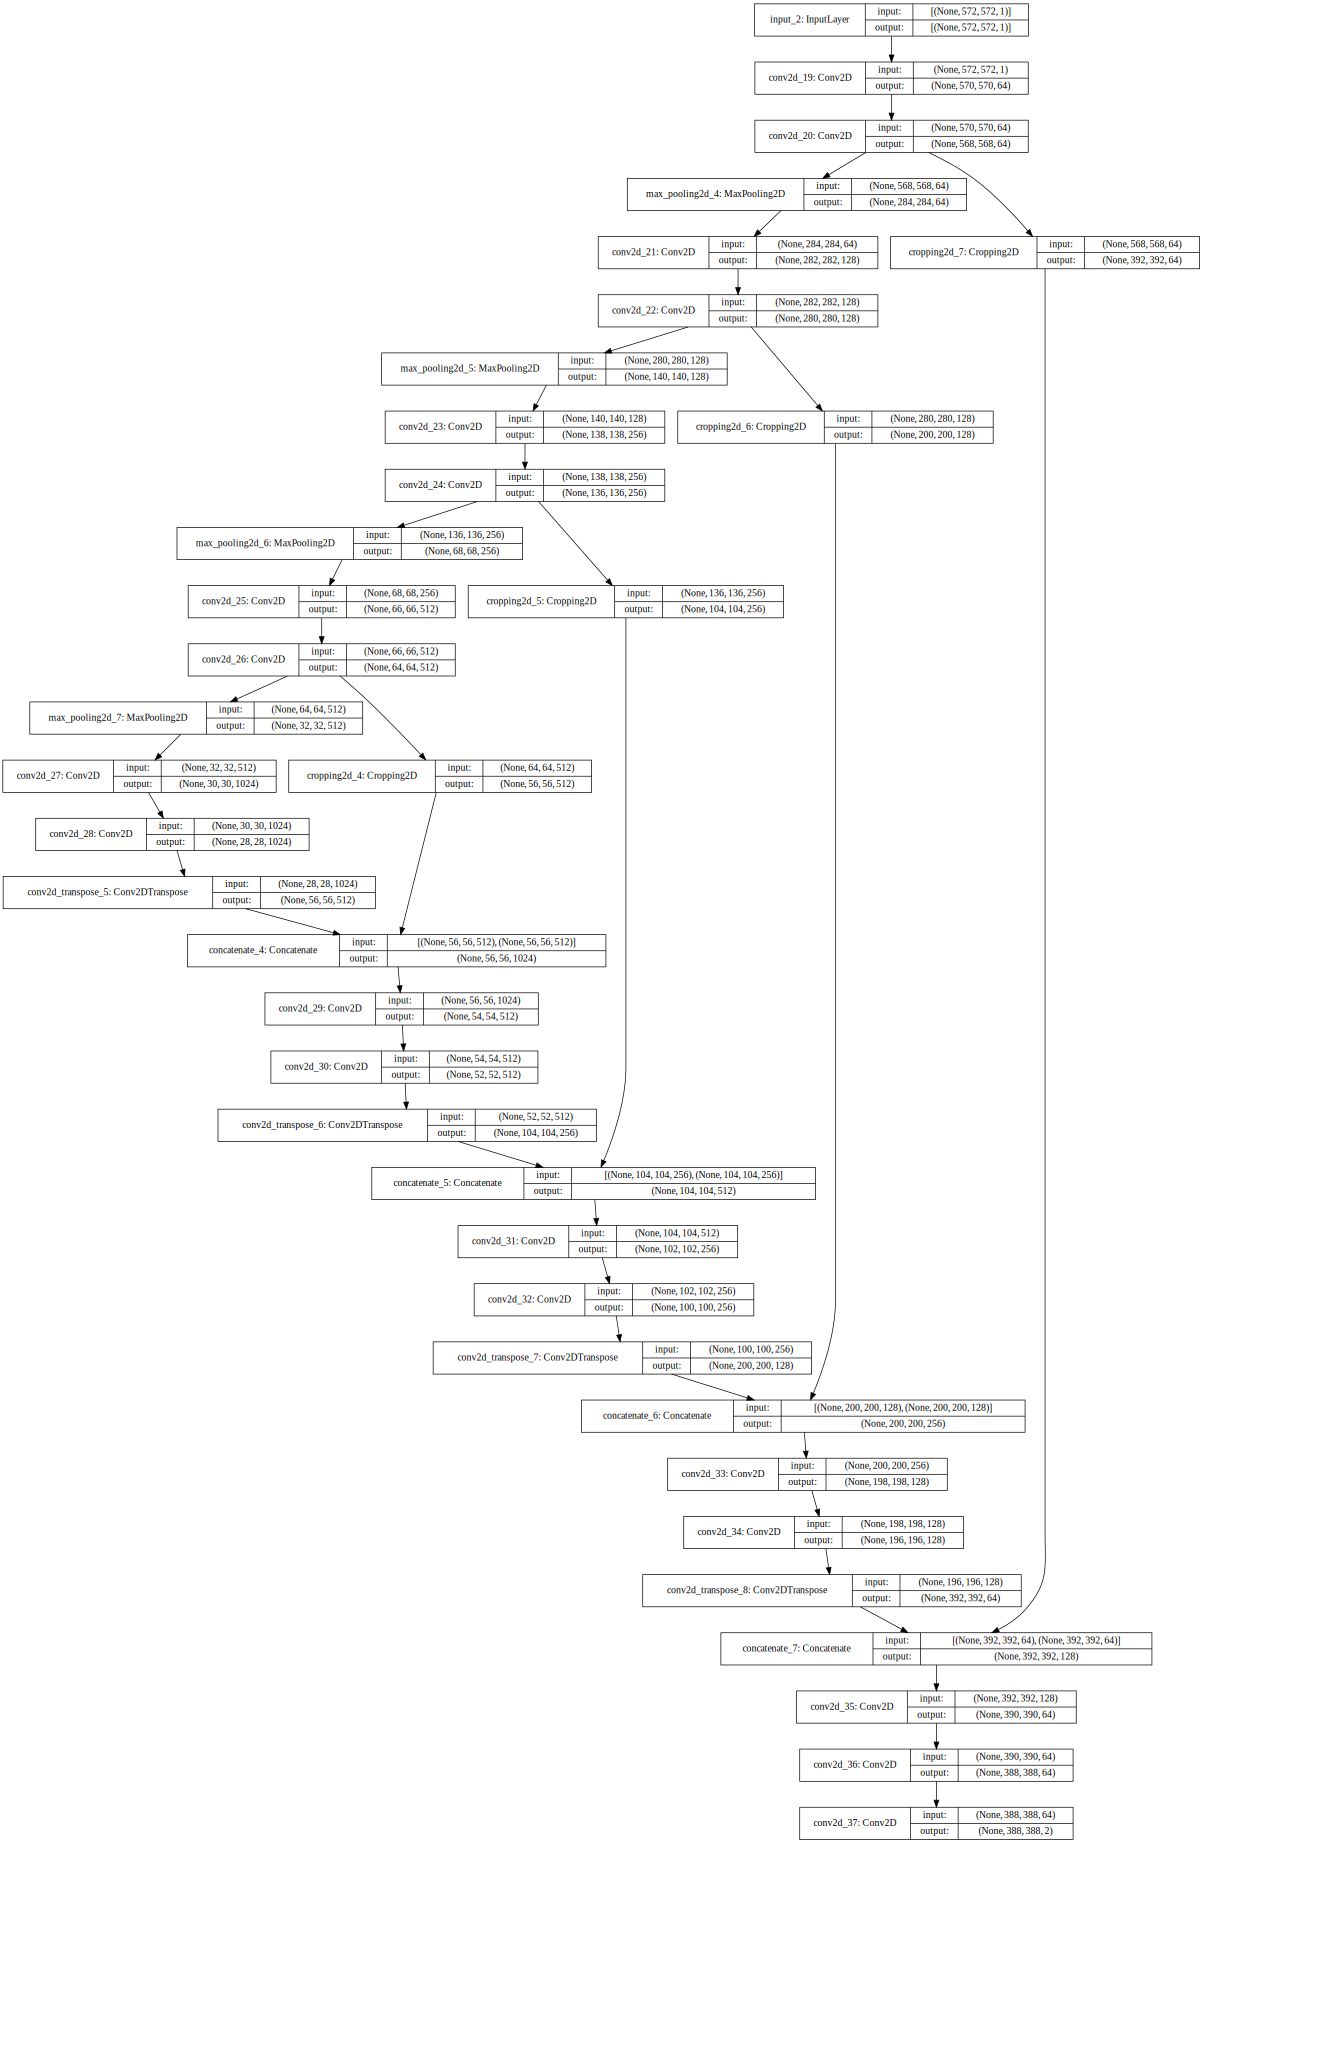

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot  

%matplotlib inline

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=80).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

### Transposed Convolution 코드로 살펴보기

In [6]:
# 필요한 모듈 불러오기 
import numpy as np
import tensorflow as tf

In [7]:
# input data 
X = np.asarray([[1, 2], 
                [3, 4]])

In [8]:
print(X) 
print(X.shape)

[[1 2]
 [3 4]]
(2, 2)


In [9]:
# 모델에 맞게 reshaping 
X = X.reshape((1, 2, 2, 1))

In [10]:
print(X)
print(X.shape)

[[[[1]
   [2]]

  [[3]
   [4]]]]
(1, 2, 2, 1)


In [11]:
# 모델 만들기 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2DTranspose(1, (1, 1), strides=(2, 2), input_shape=(2, 2, 1))) # Conv2DTranspos layer

In [12]:
weights = [np.asarray([[[[1]]]]), np.asarray([1])] # weight = 1, bias = 1
weights

[array([[[[1]]]]), array([1])]

In [13]:
model.set_weights(weights)

In [14]:
yhat = model.predict(X) 
yhat = yhat.reshape((4, 4)) # 결과를 확인하기 편하게 reshaping
print(yhat)

[[2. 1. 3. 1.]
 [1. 1. 1. 1.]
 [4. 1. 5. 1.]
 [1. 1. 1. 1.]]
